- WISDM dataset
  - sitting 4500 - (normal)
  - running 4500 - (abnormal)
- activity를 label로 설정하되 train set에서는 drop(auto encoder 기본!)

Denoising Auto Encoder(DAE)

https://github.com/francis-kang/handson-unsupervised-learning/blob/master/08_autoencoders.ipynb

In [86]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [87]:
df = pd.read_csv("/content/drive/MyDrive/WISDM.csv")
df = df.drop('user-id', axis=1)
df = df.drop('timestamp', axis=1)
df = df.drop(df.columns[0], axis=1)

Sitting = df[df['activity']=='Sitting'].head(4499).copy()
Jogging = df[df['activity']=='Jogging'].head(4500).copy()


df = pd.concat([Jogging, Sitting])
df.head()

,activity,X,Y,Z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [88]:
df['activity'].value_counts()

from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

df['activity']=le.fit_transform(df['activity'])

In [89]:
df['activity'].value_counts()

0    4500
1    4499
Name: activity, dtype: int64

- 1: Sitting(normal)
- 0: Running(abnormal)

In [90]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp

X = df.copy().drop(['activity'],axis=1)
Y = df['activity'].copy()

# 데이터 스케일
featuresToScale = X.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
X.loc[:,featuresToScale] = sX.fit_transform(X[featuresToScale])


df = pd.concat([X, Y], axis=1)

In [91]:

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.25, random_state=42)


# Normal = Sitting Fall = Jogging
normal = X_train[X_train['activity'] == 1]


y_train = normal['activity']
X_train_normal_train = normal.drop(['activity'], axis=1)


y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)


X_train = X_train_normal_train.values
X_test = X_test.values

In [92]:
X_train_AE = X_train.copy()
X_test_AE = X_test.copy()


#노이즈 넣기
noise_factor = 0.50

X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
  np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)

X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
  np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape)

In [93]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [101]:
#nb_epoch = 100
nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=(0.1),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
95/95 [==============================] - 2s 11ms/step - loss: 0.4479 - accuracy: 0.9778 - val_loss: 0.4577 - val_accuracy: 0.9791
Epoch 2/10
95/95 [==============================] - 1s 8ms/step - loss: 0.4479 - accuracy: 0.9778 - val_loss: 0.4577 - val_accuracy: 0.9791
Epoch 3/10
95/95 [==============================] - 1s 8ms/step - loss: 0.4479 - accuracy: 0.9778 - val_loss: 0.4577 - val_accuracy: 0.9791
Epoch 4/10
95/95 [==============================] - 1s 9ms/step - loss: 0.4479 - accuracy: 0.9778 - val_loss: 0.4577 - val_accuracy: 0.9791
Epoch 5/10
95/95 [==============================] - 1s 8ms/step - loss: 0.4479 - accuracy: 0.9778 - val_loss: 0.4577 - val_accuracy: 0.9791
Epoch 6/10
95/95 [==============================] - 1s 6ms/step - loss: 0.4479 - accuracy: 0.9778 - val_loss: 0.4577 - val_accuracy: 0.9791
Epoch 7/10
95/95 [==============================] - 1s 6ms/step - loss: 0.4479 - accuracy: 0.9778 - val_loss: 0.4577 - val_accuracy: 0.9791
Epoch 8/10
95/95 [=

#평가

In [102]:
autoencoder = load_model('model.h5')

In [103]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

71/71 [==============================] - 0s 2ms/step


,reconstruction_error,true_class
count,2250.000000,2250.000000
mean,0.716468,0.511111
std,0.823004,0.499988
min,0.000778,0.000000
25%,0.109720,0.000000
50%,0.703090,1.000000
75%,0.811244,1.000000
max,8.242151,1.000000


Threshold:  0.9837009178687778


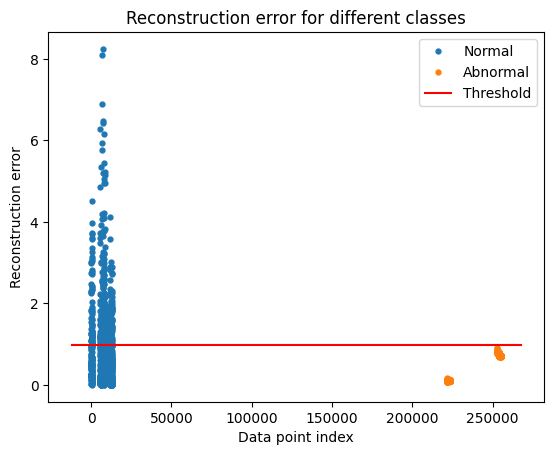

In [104]:
threshold = np.percentile(error_df.reconstruction_error.values, 80)
print("Threshold: ", threshold)


groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

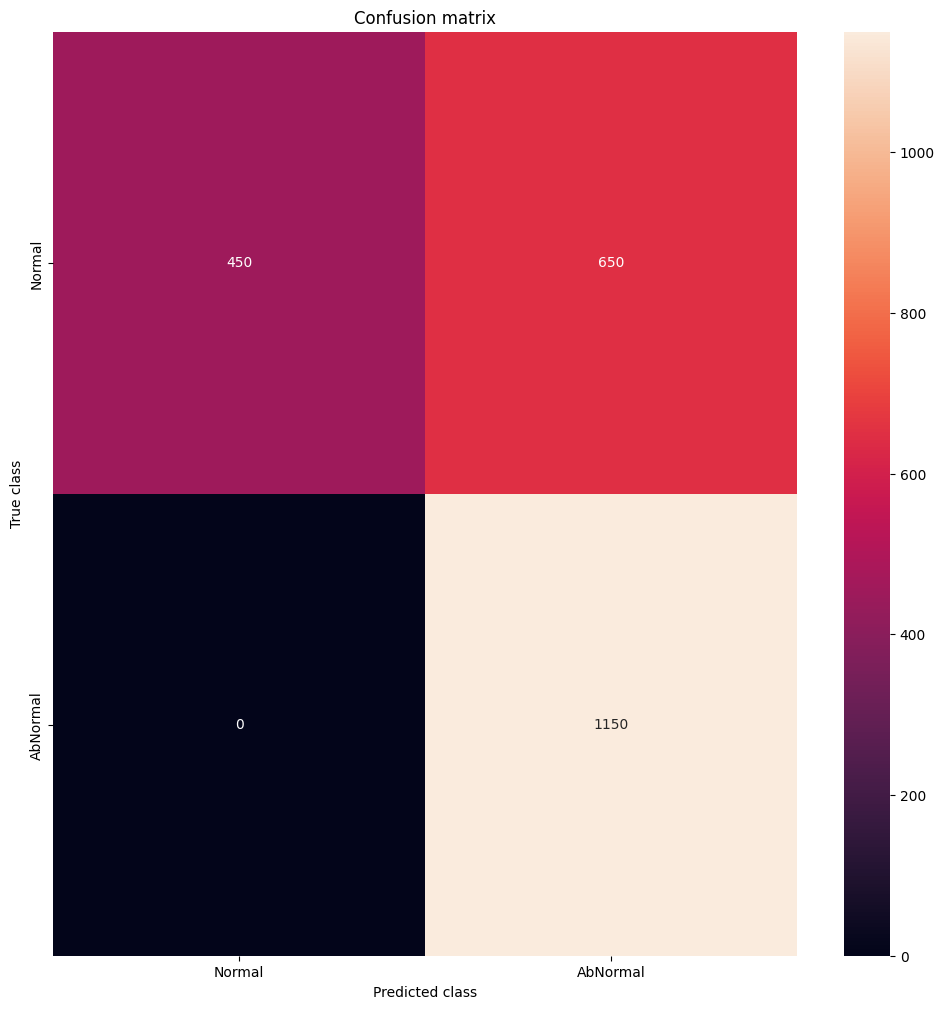

In [105]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

LABELS = ["Normal", "AbNormal"]


y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

plt.title("Confusion matrix")

plt.ylabel('True class')

plt.xlabel('Predicted class')

plt.show()

In [106]:
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )

print ('Precision :',precision )

print ('Recall :',recall )

print ('F1 :',f1 )

Accuracy Score : 0.7111111111111111
Precision : 0.6388888888888888
Recall : 1.0
F1 : 0.7796610169491525
